In [1]:
import numpy as np
from matplotlib import pyplot as plt
from time import time

# eqn to solve:

$$ \frac{d^{2}a}{d\rho^{2}} - a + \frac{3}{4}a^{3} =0 $$
for $$\rho>>0, a<<0$$
i.e looking at the tail end of the eqn
we get 
$$ \frac{d^{2}a}{d\rho^{2}} - a =0$$
the general solution is: $$a = C_{1}e^{\rho} + C_{2}e^{-\rho}$$
ignoring the growing mode, if we take $$\rho \to \infty , \implies C_{2} = 1$$
we get the condition:
$$\frac{a_{\rho}}{a}=-1 \implies (a_{\rho})_{\rho = \infty} = -a$$ 
if: $$ a = \kappa \implies a_{\rho} = -\kappa$$
at $$\rho = 0, a_{\rho} = 0$$

then we have:
$$\frac{da}{d\rho} = b$$
$$\frac{db}{d\rho} = a - \frac{3}{4}a^{3}$$

initial conditions:
b(0)=0, b(inf) = -kappa

# shooting nl:

alpha = 0.01
beta = 1.632
a = 10
b = 0

$$
F(\lambda) = a(b,\lambda) - \beta
$$
if y_1 = a, y2 = y1', we get:
$$
y_{1}' = y_{2} \;\;\; y_{1}(10)=0.01
$$

$$
y_{2}' = y_{1}-0.75y_{1}^{3} \;\;\; y_{2}(10) = \lambda
$$

with h = 0.1, the first guess for lambda0:0.1622


y2
 [0.010000050663012926, 0.009048490828510907, 0.008187474359379679, 0.0074083882852841254, 0.0067034384923018615, 0.006065572009563846, 0.005488406637656262, 0.004966167234135031, 0.00449362803303803, 0.004066060431897096, 0.0036791857316769644, 0.0033291323625677205, 0.003012397171918883, 0.0027258103901217387, 0.0024665039262145054, 0.0022318826776859713, 0.0020195985686581085, 0.0018275270575922617, 0.001653745880125623, 0.0014965158148266791, 0.0013542632797651183, 0.0012255645860119306, 0.001109131690692107, 0.001003799307163746, 0.0009085132434379946, 0.0008223198522158161, 0.0007443564870199705, 0.0006738428689528753, 0.0006100732777122112, 0.0005524094887362193, 0.0005002743858112029, 0.0004531461852288597, 0.0004105532136978438, 0.00037206918775329305, 0.00033730894742511794, 0.00030592460147066815, 0.0002776020455953149, 0.00025205781881661914, 0.0002290362665113765, 0.0002083069817537432, 0.0001896624993375273, 0.00017291621940441855, 0.00015790053989770902, 0.00014446517

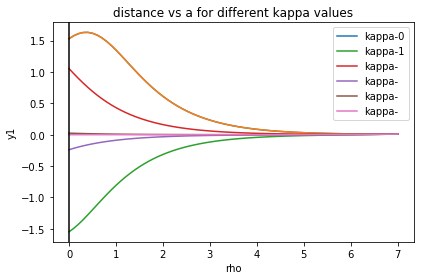

In [5]:

# functions for inegration:

def integrator(x,y1,y2,h,xend,alg):
    "integrator routine "
    while (x>xend):
        if ((x-xend)<h):
            h = h-xend
        if alg == 'rk4':
            x,ynew1,ynew2 = rk4(x,y1,y2,h)
        
        y1 = ynew1
        y2=ynew2
    return x,y1,y2


def derivatives(x,y1,y2):
    "returns dy/dx at given x and y"
    dydx1 = y2
    dydx2 = y1 - (3/4)*y1**3
    return dydx1,dydx2

def driver(x_init,x_final,dx,xout,y1,y2,alg):
    "driver function"
    
    x = x_init
    x_arr = []
    y_1_arr = []
    y_2_arr = []
    x_arr.append(x)
    y_1_arr.append(y1)
    y_2_arr.append(y2)
    m = 0
    
    while x>x_final:
        if dx>xout:
#             print("fine graining cannot be greater than coarse graining, exiting the loop...")
            break
        xend = x + xout
  
        if xend<x_final:
#             print("step size from x to the next x is too big, defaulting to xend = ",x_final)
            xend = x_final
    
        h = dx
#         if m==0:
#             print("estimated number of integrator loops = ",round(xend/h))
        
        x,y1,y2 = integrator(x,y1,y2,h,xend,alg)
        m=m+1
    
        if x < x_final:
#             print("value of calculated x exceeds limit, exiting...")
            break
    
        x_arr.append(x)
        y_1_arr.append(y1)
        y_2_arr.append(y2)
        
    return x_arr,y_1_arr,y_2_arr,m

# functions defining ode solving methods:

def rk4(x,y1,y2,h):
    "uses Runge Kutta O(4) method algorithm to calculate the next step "
    k1_1,k1_2 = derivatives(x,y1,y2)
    ym1 = y1 + k1_1*(h/2)
    ym2 = y2 + k1_2*(h/2)
    
    k2_1,k2_2 = derivatives(x+(h/2),ym1,ym2)
    ym1 = y1 + k2_1*(h/2)
    ym2 = y2 + k2_2*(h/2)
    
    k3_1,k3_2 = derivatives(x+(h/2),ym1,ym2)
    ye1 = y1 + k3_1*h
    ye2 = y2 + k3_2*h
    
    k4_1,k4_2 = derivatives(x+h,ye1,ye2)
    
    slope1  = (k1_1 + 2*(k2_1 + k3_1) + k4_1)/6
    slope2 = (k1_2 + 2*(k2_2 + k3_2) + k4_2)/6
    
    ynew1  = y1 +slope1*h
    ynew2  = y2 +slope2*h
    
    x = x+h

    return x,ynew1,ynew2
    

# shooting method functions

def shoot(lam,beta):
    f = lam - beta
    return f

def calc_lam(alpha,beta,x_init,x_final,dx,xout,n):
    lam = []
    f= []
    
    for i in range(n):
        if i ==0:
            lam0 = (beta-alpha)/(x_final-x_init)
            y2 = lam0
            y1 = alpha
            x,y1sol,y2sol,m = driver(x_init,x_final,dx,xout,y1,y2,'rk4')
                
            plt.plot(x,y1sol,label='kappa-0')
            plt.plot(x,y1sol)
            f0 = shoot(y1sol[-1],beta)
            lam.append(lam0)
            f.append(f0)
#                 print(lam0)
#                 print(f0)
        
        if i ==1:
            lam1 = float(10*lam[-1])
            y2 = lam1
            y1 = alpha
            x,y1sol,y2sol,m = driver(x_init,x_final,dx,xout,y1,y2,'rk4')
            plt.plot(x,y1sol,label='kappa-1')
            f1 = shoot(y1sol[-1],beta)
            lam.append(lam1)
            f.append(f1)
        
        if i>1:
#             print(f)
            lam2 = lam[-1]-(lam[-1]-lam[-2])*f[-1]/(f[-1]-f[-2])
            y2 = lam2
            y1 = alpha        
            x,y1sol,y2sol,m = driver(x_init,x_final,dx,xout,y1,y2,'rk4')
            plt.plot(x,y1sol,label = 'kappa-')
            f2 = shoot(y1sol[-1],beta)
            lam.append(lam2)
            f.append(f2)
                
        if abs(y2sol[-1])<1e-2:
            break
#     print(lam)
#     print(f)
#     print(x)
#     print(y1sol)
#     print(y2)
    return lam,f,x,y1sol,y2sol,m
        
        


if __name__ == "__main__":

    # initialization
    x_init = 7.# initial value of independant variable
    x_final = 0.# final value of independant variable
    dx = -0.1  # step size within the interval from one x to the next (fine graining)
    xout = -0.1
    alpha= 0.01 #shooting initial condition
    beta = 0.0  # shooting final condition
    
    #shooting
    step = 100 # number of shooting steps
    lam,f,rho,y1,y2,m = calc_lam(alpha,beta,x_init,x_final,dx,xout,step)


#     print("driver loops = ",m3+1)
#     print("driver loops exicuted in (sec) = ",e3-s3)
#     print('f\n',f)
#     print('lam\n',lam)
#     print('x\n',x)
#     print('y1\n',y1)
    print('y2\n',y2)


#     plt.plot(x,y1)
    plt.xlabel('rho')
    plt.ylabel("y1")
    plt.title('distance vs a for different kappa values')
    
#     plt.plot(p,lam)
#     plt.plot(q,lam)
#     plt.xlabel('rho')
#     plt.ylabel('kappa')
#     plt.title('distance vs kappa')

    
    plt.legend()
    plt.axvline(x=0, color = 'k')
    plt.tight_layout()
#     plt.savefig('rhovsadiffkappa')
    plt.show()

##### notes:

*b should increase with a
